# Introduction

## Disclaimer

This notebook is demonstrating an easy to implement geostatistical analysis of some soil property data. It is used to demonstrate a scientific workflow common in geosciences. This work is part of my CI-CR best practice paper. While the presented study itself does not reveal anything groundbreaking, it is conducted in a *real world* usecase manner and can easily be substituted by the respective new method, model, application or whatever is going to be published.

The main focus is the interplay of interactive features and scripting. This usecase is using Python, but the method can easily be applied to other languages used in geosciences. In Python, the interactive feaure is called a Jupyter notebook (this document), where text, images, videos and Python code can be used and compiled together. The `main.py` file in the same directory is, on the other hand, is the *scripting* part of this work. It can just be run by a Python interpreter. We utilize these two concepts to builde reproducable and easy-to-copy companion codes for scientific research. This document can be online supplementary material, focusing on implementation and derivation of methods. The script is basically doing the actual analysis and will be run in an external controlled environment on giltab. The respective results can be downloaded, archived and even published with a DOI to make them citeable. 
In gitlab, all necessary information can be copied into a private project and reused with ease.

## What is presented?

We present a geostatistical analysis of soil properties reported by Schindler & Müller (2010) from Northern Germany. The authors supply soil properties from 77 locations in the XML format. Among others bulk density and saturated hydraulic conductivity is reported. 
We will estimate spatial covariance in the topmost layer using a variogram. The variogram model best fitting the geostatistical properties of the observed data will be used to create an areal map of soil properties using Ordinary Kriging. The variogram and kriging routines are taken from Mälicke & Schneider (2019).

### References

Schindler, U., & Müller, L. (2010). Data of hydraulic properties of North East and North Central German soils. Earth System Science Data, 2(2), 189–194. https://doi.org/10.5194/essd-2-189-2010

Mälicke, M., & Schneider, H. D. (2019). mmaelicke/scikit-gstat: Version 0.2.5. https://doi.org/10.5281/zenodo.135584

# Preprocessing

The data has XML format, which is quite common and flexible, but hard to process for most hydrologic tools. We need a numerical representation and extract an array of coordinates and an array of values. This will be used as the input data for this analysis.

In order to foster reproducability, we will split the analysis into three parts, as suggested by the best practice paper:

1. *Preprocessing:* This is mainly the conversion from XML to numpy arrays.
2. *Analysis:* summarizes the application of a variogram analysis and the interpolation using Ordinary Kriging. Result will be a file of the interpolated field.
3. *Postprocessing:*: is mainly the creation of graphs and maps from the results of #2. In fact 2 and 3 do very often not show a very sharp border

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from main import xml_to_json, get_array_from_json, merge_dict, get_input_data
from main import plot_overview

plt.style.use('ggplot')

In [2]:
# get the metadata, to extract the coordinates
meta = xml_to_json('data/1977_164_1.xml')
print('Parsed %d meta elements' % len(meta))

data = xml_to_json('data/1977_164_2.xml')
print('Parsed %d data elements' % len(data))

Parsed 77 meta elements
Parsed 497 data elements


In [9]:
# get the content
names = get_array_from_json('NAME', meta)
x = get_array_from_json('X_ETRS89', meta, force_numeric=True)
y = get_array_from_json('Y_ETRS89', meta, force_numeric=True)

As you can see, there are more data entries, than meta entries. The reason for this is, that soil properties were determined at different depths, and there are also repeated samples. We need to map this into an array aswell.

In [4]:
dnames = get_array_from_json('NAME', data)
depths = get_array_from_json('BOT_DEPTH', data)
densities = get_array_from_json('BULK_DEN', data, force_numeric=True)

In [5]:
merged_data = merge_dict(dnames, depths, densities)
        
print('Merged series length: %d' % (len(merged_data.keys())))

Merged series length: 77


In [6]:
values = np.asarray([list(merged_data[_].values())[0] for _ in merged_data.keys()])

We take only the bulk density from the topmost layer and exclude the first element, as this does not have a value. The input data is created in the next cell.

In [10]:
mnames = [_ for _ in merged_data.keys()]
idx = np.asarray([np.where(names==_)[0] for _ in mnames]).flatten()
x = x[idx]
y = y[idx]
names = names[idx]

In [11]:
x = x[np.where(~np.isnan(values))]
y = y[np.where(~np.isnan(values))]
values = values[np.where(~np.isnan(values))]

The above preprocessing is summarized in one function called `get_input_data`. Get an overview of the data:

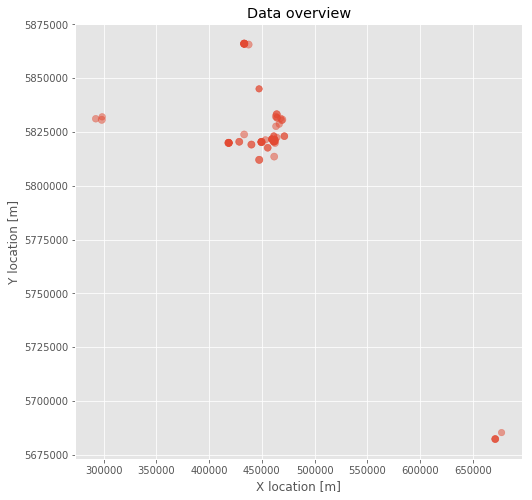

In [12]:
fig = plot_overview(x, y, values)

## Analysis

In [13]:
from skgstat import Variogram, OrdinaryKriging

In [15]:
x, y, values = get_input_data('BULK_DEN')

First, a Variogram of bulk density is built and the below cell has to be rerun to find optimal variogram parameters.

/home/mirko/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/mirko/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


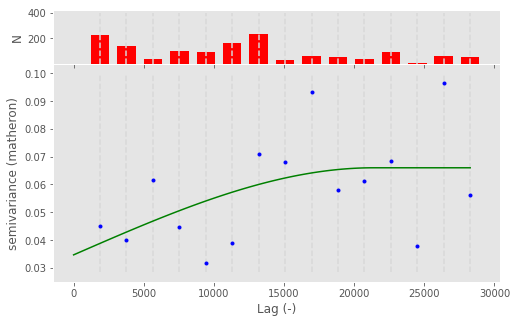

In [16]:
V = Variogram(list(zip(x, y)), values, normalize=False, maxlag='median', use_nugget=True, n_lags=15)

fig = V.plot()

/home/mirko/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/mirko/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


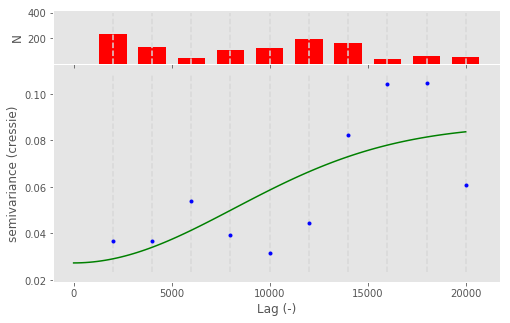

In [17]:
V = Variogram(list(zip(x, y)), values, normalize=False, 
              maxlag=20000, estimator='cressie', n_lags=10, 
              use_nugget=True, model='stable'
             )
fig = V.plot()

In [18]:
ok = OrdinaryKriging(V, min_points=5, max_points=15)

xx, yy = np.mgrid[400000:550000:100j, 5800000:5850000:100j]

res = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)

# Postprocessing

Finally, the postprocessing will be used to create a number of figures.
In a real publication, these would be used for the publication itself. For the following figure, note that the data is not really suitable for applying ordinary kriging. First, the observation locations are clustering too much and significant parts of the *study area* are not covered by observations. Second, the presented Variogram model is not describing the spatial dependence sufficiently.

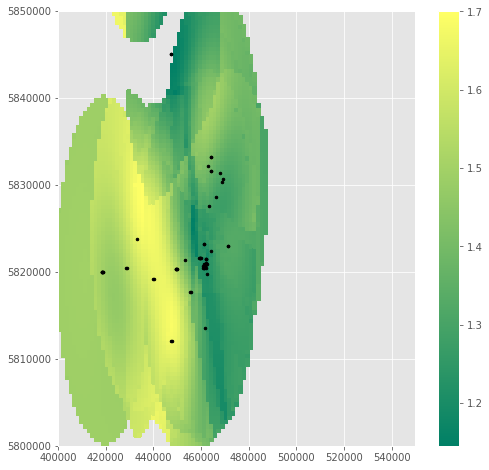

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
m = ax.pcolor(xx, yy, res, cmap='summer')
plt.colorbar(m, ax=ax)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(x, y, '.k', ms=5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.grid(which='both')